# Mask R-CNN for DeepScore

For our own dataset DeepScore

In [16]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config


%matplotlib inline 

In [18]:
import datetime
import numpy as np

# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# for mask
import pathlib
from skimage.io import imread, imsave, imshow
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patchess

import skimage

# process xml file
import xml.etree.ElementTree

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

## Configurations

In [19]:
class ScoreConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "symbols"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 114  # background + 114 symbols

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ScoreConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                127
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
M

## Notebook Preferences

In [20]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [21]:
class ScoreDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_score(self, dataset_dir, subset, split):
        """Load a subset of the DeepScore dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
    
        for key, value in class_dict.items():
            self.add_class("symbol", value, key)
        # Train or validation dataset? 
        assert subset in ["train", "val"]
        img_dir = pathlib.Path(dataset_dir).glob('*/images_png/*.png')       
        img_sorted = sorted([x for x in img_dir])
        xml_dir = pathlib.Path(dataset_dir).glob('*/xml_annotations/*.xml')       
        xml_sorted = sorted([x for x in xml_dir])
        mask_dir = pathlib.Path(dataset_dir).glob('*/pix_annotations_png/*.png')
        mask_sorted = sorted([x for x in mask_dir])
        if subset == "train":
            img_sorted = img_sorted[:split]
            xml_sorted = xml_sorted[:split]
            mask_sorted = mask_sorted[:split]
        if subset == "val":
            img_sorted = img_sorted[split:]
            xml_sorted = xml_sorted[split:]
            mask_sorted = mask_sorted[split:]
        
        # add images
        for i, image_path in enumerate(img_sorted):
            image = imread(str(image_path))
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            image_name = os.path.basename(image_path)
            xml_path = xml_sorted[i]
            symbols, _, _ = get_symbol_info(xml_path)
            mask = imread(str(mask_sorted[i]))
            
            self.add_image(
                "symbol",
                image_id=image_name,
                path=image_path,
                width=width, height=height,
                symbols=symbols, mask=mask)
        

    def image_reference(self, image_id):
        """Return the score data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "symbol":
            return info["symbol"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """        
        image_info = self.image_info[image_id]
        if image_info["source"] != "symbol":
            return super(self.__class__, self).load_mask(image_id)

        # image_id == xml_id
        symbols = image_info['symbols']
        mask = image_info['mask']
        masks = np.zeros([image_info['height'], image_info['width'], len(symbols)], dtype=np.uint8)
        for i, symbol in enumerate(symbols):
            # draw a rectangle of ones on a blank image mask
            # coords are row, col, so we should put (y, x), instead of (x, y)
            xmin, xmax, ymin, ymax = symbol[1], symbol[2], symbol[3], symbol[4]
            masks[ymin:ymax+1, xmin:xmax+1, i] = mask[ymin:ymax+1, xmin:xmax+1]
        
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in symbols])
            
        
        return masks.astype(np.bool), class_ids.astype(np.int32)

In [22]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = ScoreDataset()
    dataset_train.load_score(dataset_dir, "train", split)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = ScoreDataset()
    dataset_val.load_score(dataset_dir, "val", split)
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')

## Load Dataset

In [23]:
# Glob the training data and load a single image path
img_paths = pathlib.Path('../../').glob('*/images_png/*.png')
img_sorted = sorted([x for x in img_paths])

# mask and xml files
mask_paths = pathlib.Path('../../').glob('*/pix_annotations_png/*.png')
mask_sorted = sorted([x for x in mask_paths])

xml_paths = pathlib.Path('../../').glob('*/xml_annotations/*.xml')
xml_sorted = sorted([x for x in xml_paths])

im_path = img_sorted[0]
mask_path = mask_sorted[0]
xml_path = xml_sorted[0]
num_samples = len(img_sorted)
print(im_path)
print(len(img_sorted))
print(mask_path)
print(xml_path)
im = imread(str(im_path))
mask = imread(str(mask_path))
root = xml.etree.ElementTree.parse(str(xml_path)).getroot()
size = root.findall('size')
width = float(size[0][0].text)
height = float(size[0][1].text)

../../DeepScores_archive0/images_png/lg-100016039-aug-beethoven--page-4.png
10000
../../DeepScores_archive0/pix_annotations_png/lg-100016039-aug-beethoven--page-4.png
../../DeepScores_archive0/xml_annotations/lg-100016039-aug-beethoven--page-4.xml


In [24]:
# get the information of all symbols in one image
def get_symbol_info(xml_path):
    root = xml.etree.ElementTree.parse(str(xml_path)).getroot()
    size = root.findall('size')
    width = float(size[0][0].text)
    height = float(size[0][1].text)

    symbols = []
    symbol_names = set() # use a set to store unique symbol names
    rectangles = []

    # get the bounding box for each object, multiply with its width and height to get the real pixel coords
    for symbol in root.findall('object'):
        name = symbol.find('name').text
        xmin = round(float(symbol.find('bndbox')[0].text)*width)
        xmax = round(float(symbol.find('bndbox')[1].text)*width)
        ymin = round(float(symbol.find('bndbox')[2].text)*height)
        ymax = round(float(symbol.find('bndbox')[3].text)*height)

        current_rectangle = name, (xmin, ymin), xmax - xmin, ymax - ymin
        current_symbol = name, xmin, xmax, ymin, ymax, height, width
        rectangles.append(current_rectangle)
        symbols.append(current_symbol)
        symbol_names.add(name)
    return symbols, symbol_names, rectangles

In [25]:
class_dict = {}
symbol_type = set()
# form a universal symbol set fot the whole dataset, this can take 3 ~ 5 min
for x in xml_sorted:
    _, symbol_names,_ = get_symbol_info(x)
    symbol_type = symbol_type.union(symbol_names)

In [26]:
print('Total number of symbols in the dataset:', len(symbol_type))
# assign integer numbers for each symbol class
i = 0
for item in symbol_type:
    class_dict[item] = i
    i += 1
print(class_dict['fClef'])

Total number of symbols in the dataset: 114
63


In [27]:
# load dataset
# the directory where deepscore folder is in
dataset_dir = '../../'
# The former split number of data used as training data
# The latter num_samples - split number of data used as validation data
split = 8000

In [28]:
# Training dataset
dataset_train = ScoreDataset()
dataset_train.load_score(dataset_dir, "train", split)
dataset_train.prepare()

# Validation dataset
dataset_val = ScoreDataset()
dataset_val.load_score(dataset_dir, "val", split)
dataset_val.prepare()

In [29]:
# print("Image Count: {}".format(len(dataset_train.image_ids)))
# print("Class Count: {}".format(dataset_train.num_classes))
# for i, info in enumerate(dataset_train.class_info):
#     print("{:3}. {:50}".format(i, info['name']))

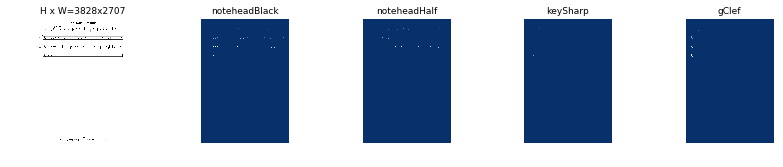

In [31]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)